<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_2/blob/main/Extend_dataset_CNN_chizai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GO extend datasetMobileNet_for_chizai**

In [1]:
import codecs
import pandas as pd
import os
import numpy as np
import random
import shutil
import re
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import pandas as pd
from PIL import Image
import tempfile
import time
import glob
import copy
import pickle
import itertools
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
!pip install torch_optimizer --q
import torch_optimizer as optim
import torch.utils.data as data
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

!pip install albumentations==0.4.6 --q
import albumentations as albu
from albumentations.pytorch import ToTensorV2

random_seed = 3 #shuffleのシード

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
!nvidia-smi
print(torch.cuda.is_available())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Tue Oct 17 08:58:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |            

#Google colabをマウント

In [2]:
'''
・dlibを用いて目を切り抜く
・横幅を2倍、縦幅を上に1倍追加/下に0.5倍追加した両眼の画像が含まれるように切り取る（目の全幅、眉毛が含まれるように）
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#残り時間確認
!cat /proc/uptime | awk '{printf("残り時間 : %.2f", 12-$1/60/60)}'


In [ ]:
# # GO_extended_datasetを colab上のフォルダに展開
# zip_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/GO_extended_dataset.zip'
# !unzip $zip_path -d "/content"
# in_path_list  = ['/content/GO_extended_dataset/Control_photo_1886mai', '/content/GO_extended_dataset/treatable']
# #保存先フォルダ
# out_path_list = ['/content/GO_extended_dataset/cont', '/content/GO_extended_dataset/grav']


#**MobileNetV3 training用フォルダを作成**

datasetをtrainとvalに分ける

https://book.st-hakky.com/docs/object-detection-yolov5-tutorial/



In [3]:
# split dataset

import numpy as np
from sklearn.model_selection import train_test_split
import glob
import os
import shutil

# periocular_for_YOLOフォルダにすでに展開されているデータセットを用いる
dataset_dir = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO"

# def split_dataset(dataset_dir):
#     img_list = glob.glob(f"{dataset_dir}/images/*")
#     img_train, img_test = train_test_split(img_list, test_size=0.3, random_state=0)

#     # img_train, img_testに名前が一致するtxtファイルを抜き出す
#     label_train = [f"{dataset_dir}/labels/{os.path.basename(i).split('.')[0]}.txt" for i in img_train]
#     label_test = [f"{dataset_dir}/labels/{os.path.basename(i).split('.')[0]}.txt" for i in img_test]

#     print(f"train: {len(label_train)},test: {len(label_test)}")

#     return img_train, img_test, label_train, label_test

def make_path_list(dir, class_name):
    image_list =  [file for file in glob.glob(f"{dir}/{class_name}/images/*") if os.path.isfile(file) == True ]
    label_list =  [f"{dir}/{class_name}/labels/{os.path.basename(i).split('.')[0]}.txt" for i in image_list]

    id_list = [os.path.basename(i).split("-")[0].split(".")[0] for i in image_list]

    index = {}
    id_idx = []
    for item in id_list:
        if item in index:
            id_idx.append(index[item])
        else:
            index[item] = len(index) + 1
            id_idx.append(index[item])
    id_idx = [int(i) for i in id_idx]

    return image_list, label_list, id_idx

grav_image_list, grav_label_list, grav_id_idx = make_path_list(dataset_dir, "grav")
cont_image_list, cont_label_list, cont_id_idx = make_path_list(dataset_dir, "cont")

print(f"grav: {len(grav_image_list)}")
print(f"cont: {len(cont_image_list)}")

grav: 1657
cont: 1656


In [ ]:
from IPython.display import Image, display
import os

# ディレクトリのパス
directory_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO/cont/images_cropped"

# ディレクトリ内のjpgファイルをリストアップ
jpg_files = [f for f in os.listdir(directory_path) if f.endswith('.JPG')]

# 1つのjpgファイルを表示
if len(jpg_files) > 0:
    file_to_display = jpg_files[0]  # 1つ目のファイルを表示
    file_path = os.path.join(directory_path, file_to_display)
    display(Image(filename=file_path))
else:
    print("指定されたディレクトリ内にjpgファイルが見つかりませんでした。")


In [ ]:
######################################################
# YOLOv5向けにGroupKfoldで仕分けられたデータセットがあるのでこれを用いる　　#
######################################################
"""

/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
-----dataset-----train-----images
              |         |--labels
              |--valid-----images
              |         |--labels
              |--dataset.yaml

"""

In [ ]:
# MobileNet用に224px四方に成形しておく
dst_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training"
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(f"{dst_folder}/train")
os.makedirs(f"{dst_folder}/valid")

In [ ]:
def convert(in_path, out_path, processing_file):
    #処理時間の計測
    start = time.time()

    l=0
    for i in processing_file:
          img = Image.open(in_path + '/' + i)
          img_new = expand2square(img, (0, 0, 0)).resize((250, 250))
          img_new.save(out_path +'/'+ i)
          print(out_path +'/'+ i)

          #切り取った画像を表示
          #plt.imshow(np.asarray(img_new))
          #plt.show()

    print('Process done!!')
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width-height)//2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, (0, (height - width) // 2))
        return result

def showInfo(in_path):
    #処理するDirectoryの設定
    file = os.listdir(in_path)
    print(len(file))

    #ここにフォルダ番号を記載する (ex. [0:999])
    processing_file = file[0:]
    print(processing_file)
    len(processing_file)
    return processing_file

In [ ]:
#元画像フォルダ
in_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images'

#保存先フォルダ
out_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training/train'
if not os.path.exists(out_path):
    os.makedirs(out_path)

processing_file = showInfo(in_path)
convert(in_path, out_path, processing_file)

#元画像フォルダ
in_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images'

#保存先フォルダ
out_path = '/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training/valid'
if not os.path.exists(out_path):
    os.makedirs(out_path)

processing_file = showInfo(in_path)
convert(in_path, out_path, processing_file)

# **Modules**

In [4]:
PX = 224 #画像のサイズ
TRAIN_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]
TRAIN_CROP_SCALE =(0.9,1.0)
#TRAIN_BRIGHTNESS_PARAM = 0.2
#TRAIN_CONTRAST_PARAM = 0.1
#TRAIN_SATURATION_PARAM = 0.1
TRAIN_RANDOM_ROTATION = 3
TRAIN_HUE_PARAM = 0.02
VAL_NORMALIZE_PARAM = [0.494, 0.296, 0.197], [0.14,  0.114, 0.072]

class Expand2square(object):
    """
    長方形の元画像を長辺を1辺とする正方形に貼り付け、空白を黒く塗りつぶす
    """
    def __init__(self, background_color):
        self.background_color = background_color

    def __call__(self, pil_img):
        width, height = pil_img.size
        if width == height:
            return pil_img
        elif width > height:
            result = Image.new(pil_img.mode, (width, width), self.background_color)
            result.paste(pil_img, (0, (width-height)//2))
            return result
        else:
            result = Image.new(pil_img.mode, (height, height), self.background_color)
            result.paste(pil_img, (0, (height - width) // 2))
            return result

class SimpleImageDataset(Dataset):
    def __init__(self, img_list, label_list, transform):
        self.transform = transform
        self.img_list = img_list
        self.label_list = label_list
        self.item_dict = {}
        self.age = []
        #print(img_list)
        #print(label_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_path = self.img_list[idx]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image)
        target = torch.tensor(self.label_list[idx])
        return tensor_image, target



#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




#Defining early stopping class

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    torch.backends.cudnn.benchmark = True

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print('-' * 10)

        ###################
        # train the model #
        ###################
        model.train() # Set model to training mode

        running_corrects, train_acc= 0, 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)


            #普通はこちらを使う
            optimizer.zero_grad()


            # Runs the forward pass with autocasting.
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            ##################################
            ##パラメータのL1ノルムの絶対値を損失関数に足す##
            ##################################
            # lam=1e-3
            # l1_loss = torch.tensor(0., requires_grad=True)
            # for w in model_ft.parameters():
            #     l1_loss = l1_loss + abs(torch.norm(w))
            # loss = loss + lam * l1_loss
            ##################################
            ##################################

            ##################################
            ##パラメータのL2ノルムの二乗を損失関数に足す##
            ##################################
            # lam=1e-3
            # l2_loss = torch.tensor(0., requires_grad=True)
            # for w in model_ft.parameters():
            #     l2_loss = l2_loss + torch.norm(w)**2
            # loss = loss + lam * l2_loss
            ##################################
            ##################################

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            # record training loss
            train_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)

        #print()
        train_acc = running_corrects.item()/len(train_dataset)

        #####################
        # validate the model#
        #####################

        model.eval()   # Set model to evaluate mode

        running_corrects, val_acc= 0, 0

        # Iterate over data.
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            """
            print("preds:"+str(preds))
            print("labels:"+str(labels))
            print("running_corrects: "+str(str(running_corrects)))
            """

            valid_losses.append(loss.item())

            running_corrects += torch.sum(preds==labels)
        val_acc = running_corrects.item()/len(val_dataset)



        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(num_epochs))

        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}' +'\n'
                     f'train_loss: {train_loss:.5f} ' +
                     f'train_acc: {train_acc:.5f}' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'valid_acc: {val_acc:.5f}')
        print(print_msg)

        """
        #Scheduler step for ReduceLROnPlateau
        scheduler.step(valid_loss)
        """

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []


        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses



#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




def Draw_roc_curve(label_list_list, model_pred_prob_list, sample_num_list, num_curves,class_names):

#グラフの外形を作成
    fig = plt.figure(figsize=(8.0, 6.0))
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ycolor = ["r", "g", "b", "c", "m", "y", "k", "w"]      # 各プロットの色
    plt.legend(loc="lower right")

    k=0
    for j in range(num_curves):
        y_score = []
        y_true = []

        for i in label_list_list[k]:
            if i == class_names[0]:
                  y_true.append(0)
            elif i == class_names[1]:
                  y_true.append(1)

        #それぞれの画像における陽性の確率についてリストを作成
        y_score = model_pred_prob_list[k]

        fpr, tpr,thred = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=ycolor[k],lw=lw, label= str(roc_label_list[k])+':ROC curve (area = %0.2f)' % roc_auc)

        k+=1

    plt.legend(loc="lower right")
    plt.show()
    return fig

def calculate_auc(label_list, model_pred_prob, class_names):
    y_true, y_score = [], []
    for i in label_list:
        if i == class_names[0]:
              y_true.append(0)
        elif i == class_names[1]:
              y_true.append(1)

    #それぞれの画像における陽性の確率についてリストを作成
    y_score = model_pred_prob

    print(y_true)
    print(len(y_true))
    print(y_score)
    print(len(y_score))

    fpr, tpr,thred = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: " +str(roc_auc))
    return(roc_auc, y_true, y_score)




In [2]:
##############################################
## Deplpy MobileNetV3
##############################################

!pip install timm --q
import timm

model_ft = timm.create_model('mobilenetv3_large_100', pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
!pip install ranger_adabelief --q
from ranger_adabelief import RangerAdaBelief
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-8, betas=(0.9,0.999), weight_decay=1e-2, weight_decouple=True)

# optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min')

##############################################
## Data augumentation
##############################################

TRAIN_RANDOM_ROTATION = 15
TRAIN_CROP_SCALE = (0.8,1.1)
TRAIN_CROP_RATE = (0.9, 1.11)
PX = 224

class GaussianBlur():
    def __init__(self, kernel_size, sigma_min=0.1, sigma_max=2.0):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.kernel_size = kernel_size

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma_min, self.sigma_max)
        img = cv2.GaussianBlur(np.array(img), (self.kernel_size, self.kernel_size), sigma)
        return Image.fromarray(img.astype(np.uint8))

train_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.RandomResizedCrop(PX, scale=TRAIN_CROP_SCALE, ratio=TRAIN_CROP_RATE),
                transforms.RandomHorizontalFlip(),
                transforms.RandomGrayscale(p=0.01),
                transforms.RandomEqualize(p=0.01),
                transforms.RandomPerspective(distortion_scale=0.6, p=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.RandomRotation(degrees=TRAIN_RANDOM_ROTATION),
                transforms.Resize(PX),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_transforms = transforms.Compose([
                #Expand2square((0,0,0)),
                transforms.Resize(PX),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


##############################################
## Dataset and dataloader
##############################################
train_csv_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train_list.csv"
val_csv_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid_list.csv"
train_parent_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training/train"
val_parent_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training/valid"


def extract_list(csv_path, parent_path): #parent_pathは画像を格納しているフォルダ
    df = pd.read_csv(csv_path, index_col=None)
    image_list = [os.path.join(parent_path, os.path.basename(i)) for i in df["image_path"]]
    label_list = df["label"]
    return image_list, label_list

train_list, train_list_label = extract_list(train_csv_path, train_parent_path)
val_list, val_list_label = extract_list(val_csv_path, val_parent_path)

#define dataset and dataloader
train_dataset = SimpleImageDataset(train_list, train_list_label, train_data_transforms)
val_dataset = SimpleImageDataset(val_list, val_list_label, val_data_transforms)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True, pin_memory=True, num_workers=0)

print(len(train_list))
print(len(val_list))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.7 MB/s eta 0:00:00


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

NameError: ignored

In [ ]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=20, num_epochs=40)


In [ ]:
# save best model
model_parent_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training"
PATH = f"{model_parent_path}/MobileNetV3_aug3.pth"
torch.save(model_ft.state_dict(), PATH)


In [3]:
##########################
# Load model 飛ばして下さい
##########################
!pip install timm --q
import timm

model_ft = timm.create_model('mobilenetv3_large_100', pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

#ネットワークの読み込み
model_parent_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training"
PATH = f"{model_parent_path}/MobileNetV3_aug3.pth"
model_ft.load_state_dict(torch.load(PATH))

NameError: ignored

In [ ]:
model_ft

In [ ]:
# ############
# ## GradCAM ##
# ############

# import torch.nn.functional as F

# def compute_gradcam(model, image_tensor, target_class=None):
#     model.eval()

#     # 最終畳み込み層の出力とその勾配を取得するためのhooks
#     features_blobs = []
#     grads_blobs = []

#     def hook_feature(module, input, output):
#         features_blobs.append(output.data.cpu().numpy())

#     def hook_grad(module, grad_in, grad_out):
#         grads_blobs.append(grad_out[0].data.cpu().numpy())

#     # 最後の畳み込み層を取得します (MobileNetV3の場合は、特定の層名を指定することができます。)
#     final_conv = model.blocks[-1]  # この部分はモデルの構造により調整が必要
#     final_conv.register_forward_hook(hook_feature)
#     final_conv.register_backward_hook(hook_grad)

#     # 順伝播と逆伝播を実行
#     output = model(image_tensor)
#     if target_class is None:
#         target_class = output.argmax().item()
#     model.zero_grad()
#     one_hot = torch.zeros_like(output)
#     one_hot[0][target_class] = 1
#     output.backward(gradient=one_hot.to(device))

#     # Grad-CAMの計算
#     activations = features_blobs[0]
#     grads = grads_blobs[0]
#     weights = np.mean(grads, axis=(2, 3))[0, :]
#     cam = np.zeros_like(activations[0, 0, :, :], dtype=np.float32)
#     for i, w in enumerate(weights):
#         cam += w * activations[0, i, :, :]
#     cam = np.maximum(cam, 0)
#     cam = cv2.resize(cam, (numpy_image.shape[1], numpy_image.shape[0]))  # 元の画像のサイズに合わせて調整
#     cam = cam - np.min(cam)
#     cam = cam / np.max(cam)

#     return cam


In [6]:
import torch
import numpy as np
import cv2

############
## GradCAM ##
############

def compute_gradcam(model, image_tensor, target_class=None):
    model.eval()

    features = None
    grads = None

    def hook_feature(module, input, output):
        nonlocal features
        features = output

    def hook_grad(module, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    final_conv = model.blocks[-1]  # この部分はモデルの構造により調整が必要
    final_conv.register_forward_hook(hook_feature)
    final_conv.register_backward_hook(hook_grad)

    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax().item()

    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1
    output.backward(gradient=one_hot)

    with torch.no_grad():
        activations = features.cpu().numpy()
        grad_values = grads.cpu().numpy()
        weights = np.mean(grad_values, axis=(2, 3))[0, :]
        cam = np.zeros_like(activations[0, 0, :, :], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

    # Memory clean-up
    del features, grads, activations, grad_values, weights
    torch.cuda.empty_cache()  # If you're using CUDA

    return cam


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import gc  # Import garbage collector module

###################################
# Inference MobileNetV3 ※メモリ対策バージョン#
###################################

model_ft.to(device)
model_ft.eval()  # prep model for evaluation
targets, probs, preds, misclassified_indices = [], [], [], []


# misclassified = [17, 24, 25, 28, 68, 70, 101, 121, 200, 210, 211, 214, 215, 218, 221, 271, 291, 316, 323, 343, 344, 363, 384, 440, 448, 485, 526, 531, 544, 546, 558, 561, 568, 586, 617, 627, 629, 641, 649]
# image_indices = misclassified

image_indices = list(range(0, 665))
for i, (img_path, img_label) in enumerate(zip(val_list, val_list_label)):
    if i in image_indices:
        pilr_image = Image.open(img_path).convert("RGB")

        # Convert the PIL Image to numpy array
        numpy_image = np.array(pilr_image)
        cv2_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
        image_tensor = test_data_transforms(pilr_image)
        image_tensor = image_tensor.unsqueeze(0).to(device)

        # Compute Grad-CAM for class 0
        cam_class_0 = compute_gradcam(model_ft, image_tensor, target_class=0)
        heatmap_0 = cv2.applyColorMap(np.uint8(255 * cam_class_0), cv2.COLORMAP_JET)
        heatmap_0 = cv2.cvtColor(heatmap_0, cv2.COLOR_BGR2RGB)

        # Compute Grad-CAM for class 1
        cam_class_1 = compute_gradcam(model_ft, image_tensor, target_class=1)
        heatmap_1 = cv2.applyColorMap(np.uint8(255 * cam_class_1), cv2.COLORMAP_JET)
        heatmap_1 = cv2.cvtColor(heatmap_1, cv2.COLOR_BGR2RGB)

        # Resize the heatmaps
        heatmap_0_resized = cv2.resize(heatmap_0, (cv2_image.shape[1], cv2_image.shape[0]))
        heatmap_1_resized = cv2.resize(heatmap_1, (cv2_image.shape[1], cv2_image.shape[0]))

        # Overlay original image with the heatmaps
        overlayed_image_0 = cv2.addWeighted(cv2_image, 0.5, heatmap_0_resized, 0.5, 0)
        overlayed_image_1 = cv2.addWeighted(cv2_image, 0.5, heatmap_1_resized, 0.5, 0)

        # Concatenate the images
        result = np.hstack([cv2_image, overlayed_image_1, overlayed_image_0])
        cv2_imshow(result)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_ft(image_tensor)
        _, pred = torch.max(output, 1)

        prob = nn.Softmax(dim=1)(output)  # calculate probability
        prob = prob[0][1].cpu().detach()  # probability of being positive
        prob = "{:.3f}".format(prob.item())
        print(f"{os.path.basename(img_path)}")
        print(f"target: {img_label}, prob: {prob}, pred: {pred.item()}")
        print("")

        # Append results
        probs.append(float(prob))  # predicted probability
        preds.append(int(pred))  # predicted result
        targets.append(int(img_label))  # label

        if int(pred) != int(img_label):
            misclassified_indices.append(i)

        # Cleanup
        del pilr_image, numpy_image, cv2_image, image_tensor, cam_class_0, cam_class_1, heatmap_0, heatmap_1
        gc.collect()  # Run garbage collector

y_label = np.array(targets)
y_pred = np.array(preds)
y_prob = np.array(probs)
print(f"misclassified_indices: {misclassified_indices}")

In [1]:
########################################
# Interference MobileNetV3 (GradCAMなしバージョン)#
########################################

#define dataset and dataloader
test_dataset = SimpleImageDataset(val_list, val_list_label, test_data_transforms)
test_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False, pin_memory=True, num_workers=0) #val_datasetを1枚ずつにしてtest_loadeerに格納

model_ft.to(device)
model_ft.eval() # prep model for evaluation
targets, probs, preds =[], [], []
for image_tensor, target in test_loader:
      #target = target.squeeze(1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model_ft(image_tensor)
      _, pred = torch.max(output, 1)

      prob = nn.Softmax(dim=1)(output) #calculate probalility
      prob = prob[0][1].cpu().detach() #probalility of being positive
      prob = "{:.3f}".format(prob.item())
      print(f"target: {target.item()}, prob: {prob}, pred: {pred.item()}")


      probs.append(float(prob)) #予測確率
      preds.append(int(pred))  #予測結果
      targets.append(int(target)) #ラベル
y_label = np.array(targets)
y_pred = np.array(preds)
y_prob = np.array(probs)

NameError: ignored

In [ ]:
import gc  # Import garbage collector module
import os

######################################
# Inference MobileNetV3 ※GradCAMなし#
######################################

model_ft.to(device)
model_ft.eval()  # prep model for evaluation
paths, targets, probs, preds = [], [], [], []

image_indices = list(range(0, 665))
for i, (img_path, img_label) in enumerate(zip(val_list, val_list_label)):
    if i in image_indices:
        pilr_image = Image.open(img_path).convert("RGB")

        # Convert the PIL Image to numpy array
        numpy_image = np.array(pilr_image)
        cv2_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
        image_tensor = test_data_transforms(pilr_image)
        image_tensor = image_tensor.unsqueeze(0).to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_ft(image_tensor)
        _, pred = torch.max(output, 1)

        prob = nn.Softmax(dim=1)(output)  # calculate probability
        prob = prob[0][1].cpu().detach()  # probability of being positive
        prob = "{:.3f}".format(prob.item())
        print(f"{os.path.basename(img_path)}")
        print(f"target: {img_label}, prob: {prob}, pred: {pred.item()}")
        print("")

        # Append results
        paths.append(str(os.path.basename(img_path)))
        probs.append(float(prob))  # predicted probability
        preds.append(int(pred))  # predicted result
        targets.append(int(img_label))  # label

        # Cleanup
        del pilr_image, numpy_image, cv2_image, image_tensor
        gc.collect()  # Run garbage collector

y_label = np.array(targets)
y_pred = np.array(preds)
y_prob = np.array(probs)
print(f"misclassified_indices: {misclassified_indices}")

In [ ]:
# Convert to DataFrame
df = pd.DataFrame({
    'paths': paths,
    'Target': y_label,
    'Probability': y_prob,
    'Prediction': y_pred
})
pd.set_option('display.max_rows', 700)

file_path = "/content/result_list.csv"
df.to_csv(file_path, index=False)

df

In [ ]:
y_label
y_pred
y_prob

In [ ]:
model_ft

Accuracy: 0.9292168674698795
304 28 19 313
confusion matrix = 
 [[313  19]
 [ 28 304]]
Accuracy : 0.9292168674698795
Precision (true positive rate) : 0.9411764705882353
Recall (sensitivity): 0.9156626506024096
Specificity : 0.9427710843373494
F1 score : 0.9282442748091603


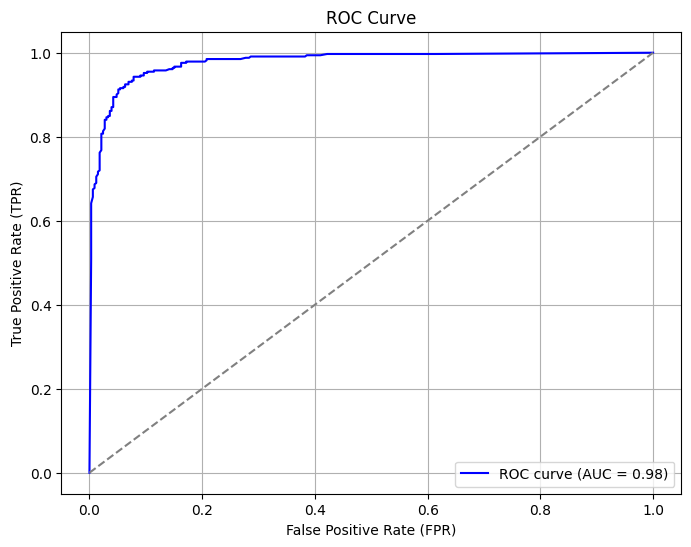

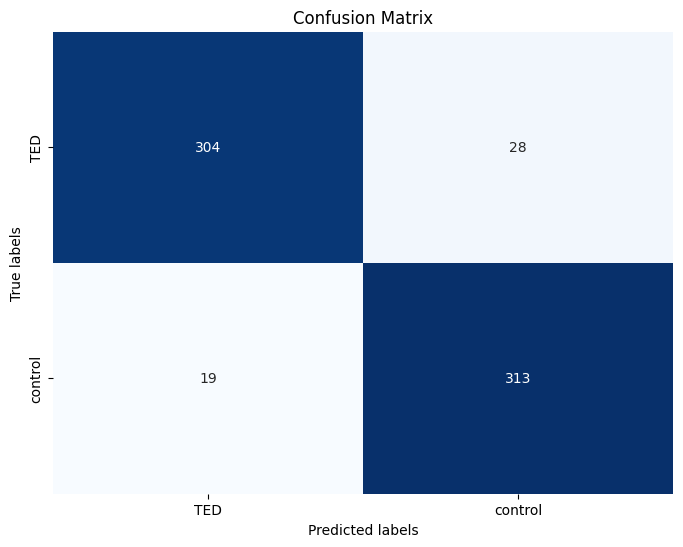

In [11]:
import statistics
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

%matplotlib inline

# #################################################
# threshold = 0.5 #判定基準。ここは先に入力しておく
# #################################################


accuracy = []
precision = []
recall = []
specificity = []
f1score = []
area_u_ROC = []

#TP_list, FN_list, FP_list, FN_list = [], [], [], []
#confusion_list = [[] for i in range(4)]  #[[TP],[FN],[FP],[FN]]
confusion_arr = np.zeros((2,2))


# X = y_prob
# Y = y_label

# Y_pred_proba = X
# Y_pred = np.where(Y_pred_proba >= threshold, 1, 0)

acc = accuracy_score(y_label, y_pred)
print('Accuracy:',acc)

tn, fp, fn, tp = confusion_matrix(y_label, y_pred).ravel()
print(tp, fn, fp, tn)

def specificity_score(label, pred):
    tn, fp, fn, tp = confusion_matrix(label, pred).flatten()
    return tn / (tn + fp)

print('confusion matrix = \n', confusion_matrix(y_label, y_pred))
print(f'Accuracy : {accuracy_score(y_label, y_pred)}')
print(f'Precision (true positive rate) : {precision_score(y_label, y_pred)}')
print(f'Recall (sensitivity): {recall_score(y_label, y_pred)}')
print(f'Specificity : {specificity_score(y_label, y_pred)}')
print(f'F1 score : {f1_score(y_label, y_pred)}')

#ROC curve

# Compute the ROC curve values
fpr, tpr, thresholds = roc_curve(y_label, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_score(y_label, y_prob):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# fpr, tpr, thresholds = roc_curve(y_label, y_pred)
# plt.plot(fpr, tpr, marker='o')
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.grid()
# print(f'Area_under_ROC : {roc_auc_score(y_label, y_pred)}')
#plt.savefig('plots/roc_curve.png')

accuracy.append(accuracy_score(y_label, y_pred))
precision.append(precision_score(y_label, y_pred))
recall.append(recall_score(y_label, y_pred))
specificity.append(specificity_score(y_label, y_pred))
f1score.append(f1_score(y_label, y_pred))
area_u_ROC.append(roc_auc_score(y_label, y_pred))

print("")


# confusion matrixをheatmapで表示
cm = confusion_matrix(y_label, y_pred, labels=[1, 0])

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['TED', 'control'],
            yticklabels=['TED', 'control'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#**Export MobileNetV3 model to CoreML**

In [ ]:
###########################
# Output as CoreML
###########################

import torch
import torchvision
!pip install --quiet coremltools
import coremltools as ct

# Load a pre-trained version of MobileNetV3
class TorchClassificationModel(nn.Module):
    def __init__(self):
        super(TorchClassificationModel, self).__init__()
        self.layers = nn.Sequential(
            model_ft,
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.layers(x)


# Set the model in evaluation mode
torch_model = TorchClassificationModel().eval()
torch_model = torch_model.to("cpu")


# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
#import urllib
#label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
#class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = ["cont", "grav"]



# Convert to Core ML using the Unified Conversion API
# mlmodel = ct.convert(
#     traced_model,
#     inputs=[ct.ImageType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
#     classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
# )


#Set the image scale and bias for input image preprocessing.
scale = 1.0 / (255.0 * 0.226)
red_bias = -0.485 / 0.226
green_bias = -0.456 / 0.226
blue_bias = -0.406 / 0.226

mlmodel = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input_1", shape=example_input.shape, scale=scale, bias=[red_bias, green_bias, blue_bias])],
    classifier_config=ct.ClassifierConfig(class_labels)
)

# Save model
model_parent_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/250px_for_MobileNetV3_training"
mlmodel.save(f"{model_parent_path}/MobileNetV3_extended.mlmodel")


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 665/665 [00:00<00:00, 1664.59 ops/s]


#**Make folders for YOLO5 training**

In [ ]:
#YOLOv5トレーニング用
#もしdst_folderがあれば削除して新しく作り直す
dst_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training"

if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
for i in ["train", "valid"]:
    for j in ["images", "labels"]:
        os.makedirs(f"{dst_folder}/{i}/{j}")
        #os.makedirs(f"{dst_folder}/labels")

for file in img_train[0]:
    shutil.copy(file, f"{dst_folder}/train/images/{os.path.basename(file)}")
for file in img_val[0]:
    shutil.copy(file, f"{dst_folder}/valid/images/{os.path.basename(file)}")
for file in label_train[0]:
    shutil.copy(file, f"{dst_folder}/train/labels/{os.path.basename(file)}")
for file in label_val[0]:
    shutil.copy(file, f"{dst_folder}/valid/labels/{os.path.basename(file)}")


In [ ]:
%cd $dst_folder

/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training


In [ ]:
%%writefile dataset.yaml
# path
train: /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images
val: /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images

# num of classes
nc: 2

#class names
names: ['cont', 'grav'] # class名を定義

Writing dataset.yaml


#**Setup YOLOv5**

In [ ]:
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 31.0/166.8 GB disk)


#**Train YOLOv5**

In [ ]:
# Train
!python train.py --img 640 --batch 16 --epochs 100 --data /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/dataset.yaml --weights yolov5n.pt


In [ ]:
# best.pyをrenameしてgdriveに移動しておく
orig_pt = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolov5/runs/train/exp/weights/best.pt"
dst_pt = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"
shutil.copy(orig_pt, dst_pt)

'/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt'

#**YOLOv5 Intereference**

In [ ]:
# Inference (folder内全部)
!python detect.py --weights /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt --img 640 --conf 0.25 --source /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images

In [ ]:
valid = os.listdir("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images")
train = os.listdir("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images")

print(len(train), len(valid))

2649 664


In [ ]:
# Interference (per image)
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/gravcont_yolo5n.pt"
image_path = glob.glob("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images/*")
img = image_path[100]

In [ ]:
!python detect.py --weights /content/drive/MyDrive/Deep_learning/GO_extended_dataset/gravcont_yolo5n.pt --img 640 --conf 0.25 --source $img

detect: weights=['/content/drive/MyDrive/Deep_learning/GO_extended_dataset/gravcont_yolo5n.pt'], source=/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images/6540.JPG, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
image 1/1 /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images/6540.JPG: 448x640 1 grav, 18.4ms
Speed: 0.7ms pre-process, 18.4ms inference, 38.0ms NMS per i

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    print(img_tensor.shape)

    print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/gravcont_yolo5n.pt"
image_path = glob.glob("/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid/images/*")
img = image_path[2]

class_names = {0:"cont", 1:"grav"}
pred = interference(img, weight)

# probability
prob = pred[0][0][4].item()

# class
class_name = class_names[pred[0][0][5].item()]

print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

img_cv2 = cv2.imread(img)
cv2_imshow(img_cv2)


#**Interference Olympia dataset**

In [ ]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.9/166.8 GB disk)


In [ ]:
# YOLOv5
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

# 横幅を640pxにリサイズしたデータセット
dataset_grav = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/treated_640px"
dataset_cont = "/content/drive/MyDrive/Deep_learning/Olympia_dataset/untreated_640px"

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    device = 'cpu'
    device = select_device(device)
    model = DetectMultiBackend(weight, device=device, dnn=False)
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
image_path = glob.glob(f"{dataset_grav}/*")
img = image_path[100]

class_names = {0:"cont", 1:"grav"}
pred = interference(img, weight)

# output result
x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

# probability
prob = pred[0][0][4].item()

# class
class_name = class_names[pred[0][0][5].item()]

print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

img_cv2 = cv2.imread(img)

# calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
img_height, img_width, _ = img_cv2.shape[:3]
print(f"img_height: {img_height}, img_width: {img_width}")
padding_x = (img_height - min(img_width, img_height))/2
padding_y = (img_width - min(img_width, img_height))/2
x1 = x1 - padding_x
y1 = y1 - padding_y
x2 = x2 - padding_x
y2 = y2 - padding_y
print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")


# draw bounding box
cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)


# show image
cv2_imshow(img_cv2)

#**Export coreML including non-max supression**

In [ ]:
# clone Yolov5 repo
import os
%cd /content
!git clone https://github.com/hietalajulius/yolov5.git
%cd yolov5
!pip install -r requirements.txt -r requirements-export.txt

In [ ]:
weight_path = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"

In [ ]:
!python export-nms.py --include coreml --weights $weight_path


#**Interference and crop Extended dataset**

In [ ]:
# Setup YOLOv5
%cd /content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 24.9/166.8 GB disk)


In [ ]:
# パスを指定する
weight = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/yolo5n_100epoch.pt"
input_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train/images"
output_folder = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train"

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync
from utils.augmentations import letterbox #padding

from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np

#サポートパッチのインポート
from google.colab.patches import cv2_imshow


def interference(img, weight):
    #stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
    #imgsz = check_img_size([640], s=stride)  # check image size

    #class_names = {0:"cont", 1:"grav"}

    # transform = transforms.Compose([
    #             transforms.Resize(size=(480,640)),
    #             transforms.ToTensor(),
    #             # transforms.Normalize(
    #             #     mean=[0.5, 0.5, 0.5],
    #             #     std=[0.5, 0.5, 0.5]
    #             #    )
    #             ])

    img_cv2 = cv2.imread(img) #CV2で開く
    img_cv2 = letterbox(img_cv2, (640,640), stride=32, auto=False)[0] #resize, 上下padding (color 114)

    #cv2_imshow(img_cv2)

    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    #img_tensor = transform(img_np)
    img_tensor /= 255
    #print(img_tensor.shape)

    #print(img_tensor)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


    pred = model(img_tensor, visualize=False, augment=False)

    pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None,  max_det=1000)

    print(f"pred: {pred}")

    return pred

In [ ]:
from tqdm import tqdm
import os

# image_path = glob.glob(f"{dataset_grav}/*")
# img = image_path[100]

class_names = {0:"cont", 1:"grav"}

device = 'cpu' # device = None or 'cpu' or 0 or '0' or '0,1,2,3'
device = select_device(device)
model = DetectMultiBackend(weight, device=device, dnn=False)

os.makedirs(output_folder, exist_ok=True)

for img in tqdm(glob.glob(f"{input_folder}/*")):

    pred = interference(img, weight)

    # output result
    x1, y1, x2, y2, prob, class_num = torch.round(pred[0][0])

    # probability
    prob = pred[0][0][4].item()

    # class
    class_name = class_names[pred[0][0][5].item()]

    print("診断は %s、確率は%.1f％です。" %(class_name, prob*100))

    img_cv2 = cv2.imread(img)

    # calculate coordinates of the bounding box (640*640にpaddingされている分の座標を足す)
    img_height, img_width, _ = img_cv2.shape[:3]
    print(f"img_height: {img_height}, img_width: {img_width}")
    padding_x = (img_height - min(img_width, img_height))/2
    padding_y = (img_width - min(img_width, img_height))/2
    x1 = x1 - padding_x
    y1 = y1 - padding_y
    x2 = x2 - padding_x
    y2 = y2 - padding_y
    print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")

    # draw bounding box
    #cv2.rectangle(img_cv2, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

    # show image
    #cv2_imshow(img_cv2)

    # バウンディングボックスで画像を切り抜く」

    if x1 < 0: #負の場合のエラー回避
        x1 = 0

    cropped_image = img_cv2[int(y1):int(y2), int(x1):int(x2)]

    # 切り抜いた画像を保存する
    save_path = f"{output_folder}/{os.path.basename(img)}"
    print(save_path)
    #cv2_imshow(cropped_image)
    cv2.imwrite(save_path, cropped_image)

In [ ]:
#rewrite csv file (bootcamp用csvのimage_pathを改変)
import pandas as pd

csv_1_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/train_list.csv"
csv_2_orig = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_for_YOLO_training/valid_list.csv"
csv_1 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/train_list.csv"
csv_2 = "/content/drive/MyDrive/Deep_learning/GO_extended_dataset/periocular_cropped_using_YOLO/valid_list.csv"

def rewrite_csv(df):
    path_list = []
    for path in df["image_path"]:
        path = path.replace("periocular_for_YOLO_training", "periocular_cropped_using_YOLO")
        path = path.replace("images/", "")
        path_list.append(path)
    df["image_path"] = path_list
    return(df)

df = pd.read_csv(csv_1_orig)
df = rewrite_csv(df)
print(df)
df.to_csv(csv_1, index=False)

df = pd.read_csv(csv_2_orig)
df = rewrite_csv(df)
df.to_csv(csv_2,  index=False)